# Training a digit classifier from scratch

In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

E:\Conda\envs\fastai2-env\lib\site-packages\fastbook\__init__.py:21: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In order to understand what happens in a computer vision model, we first have to understand how computers handle images. We'll use one of the most famous datasets in computer vision, MNIST, for our experiments. MNIST contains images of handwritten digits

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [7]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the labels (or targets) in this dataset. Let's take a look in one of these folders (using sorted to ensure we all get the same order of files)

In [11]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()
threes, sevens

((#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...],
 (#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...])

In [19]:
three = threes[1]
img = Image.open(three)
img

Here we are using the Image class from the Python Imaging Library (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor.

In [20]:
tensor(img)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [22]:
array(img)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values.

In [24]:
im3_t = tensor(img)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Pixel similarity : baseline model

So, here is a first idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

In [71]:
stacked_threes = [tensor(Image.open(o)) for o in threes]
stacked_sevens =  [tensor(Image.open(o)) for o in sevens]
len(stacked_threes), len(stacked_sevens)

(6131, 6265)

<AxesSubplot:>

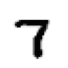

In [72]:
show_image(stacked_sevens[0])

In [73]:
stacked_threes = torch.stack(stacked_threes).float()/255
stacked_sevens = torch.stack(stacked_sevens).float()/255

In [74]:
print('shape of 3s: {a} and shape of sevens: {b}'.format(a = stacked_threes.shape, b= stacked_sevens.shape))

shape of 3s: torch.Size([6131, 28, 28]) and shape of sevens: torch.Size([6265, 28, 28])


<AxesSubplot:>

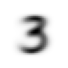

In [75]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

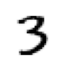

In [77]:
a_3 = stacked_threes[1]
show_image(a_3)

In [78]:
dist3_abs = (a_3 - mean3).abs().mean()
dist3_rmse = ((a_3 - mean3)**2).mean().sqrt()
dist3_abs, dist3_rmse

(tensor(0.1114), tensor(0.2021))

In [80]:
F.l1_loss(a_3, mean3), F.mse_loss(a_3, mean3).sqrt()

(tensor(0.1114), tensor(0.2021))

## Computing Metrics

In [84]:
valid_3 = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls()])
valid_3 = valid_3.float()/255

valid_7 = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls()])
valid_7 = valid_7.float()/255
valid_3.shape, valid_7.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

We ultimately want to write a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

In [91]:
def distance(ins ,target): return (ins-target).abs().mean((-1,-2))
distance(valid_3, mean3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

In [93]:
def is_3(a): return distance(a,mean3) < distance(a, mean7) 
is_3(valid_3)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [94]:
accuracy_3s = is_3(valid_3).float().mean()
accuracy_7s = (1 - is_3(valid_7).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This looks like a pretty good start! We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

## SGD MNIST(3,7)

In [103]:
train_x = torch.cat((stacked_threes,stacked_sevens)).view(-1,784)

In [109]:
stacked_threes.shape, stacked_sevens.shape, train_x.shape

(torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([12396, 784]))

In [115]:
train_y = tensor([1]*len(threes) + [0]*len(stacked_sevens)).unsqueeze(1)

In [116]:
train_y.shape

torch.Size([12396, 1])

In [119]:
train_dst = list(zip(train_x, train_y))
x,y = train_dst[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [120]:
valid_x = torch.cat((valid_3,valid_7)).view(-1,784)
valid_y = tensor([1]*len(valid_3) + [0]*len(valid_7)).unsqueeze(1)
valid_dst = list(zip(valid_x, valid_y))

In [197]:
init_params = nn.Linear((28*28),1)

In [198]:
class Basic_optim:
    def __init__(self, params,lr):
        self.params = list(params)
        self.lr = lr
    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    def zero_grad(self):
        for p in self.params: p.grad = None

In [199]:
opt = Basic_optim(init_params.parameters(),1)

In [137]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [138]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [192]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb,yb, model)
        opt.step()
        opt.zero_grad()
        
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [193]:
dl = DataLoader(train_dst , batch_size=256)
valid_dl = DataLoader(valid_dst, batch_size=256)

In [194]:
xb, yb = next(iter(dl))

In [195]:
def train_model(model, epoch):
    for i in range(epoch):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [200]:
train_model(init_params,20)

0.4932 0.4932 0.668 0.8701 0.9185 0.936 0.9502 0.958 0.9638 0.9658 0.9682 0.9692 0.9721 0.9736 0.9746 0.9756 0.977 0.978 0.978 0.978 

## Using Fastai SGD

In [201]:
init_params = nn.Linear(28*28,1)

In [202]:
opt = SGD(init_params.parameters(),1)

In [203]:
train_model(init_params, 40)

0.4932 0.8184 0.8472 0.9141 0.9336 0.9468 0.9551 0.9624 0.9658 0.9673 0.9692 0.9717 0.9736 0.9751 0.9761 0.9761 0.9775 0.978 0.978 0.979 0.979 0.979 0.9785 0.979 0.9795 0.98 0.98 0.98 0.9814 0.9819 0.9819 0.9819 0.9814 0.9814 0.9809 0.9809 0.9814 0.9814 0.9814 0.9814 

fastai also provides Learner.fit, which we can use instead of train_model. To create a Learner we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [205]:
DataLoaders??

In [206]:
dls = DataLoaders(dl, valid_dl)

In [207]:
learn = Learner(dls, nn.Linear(28*28,1), mnist_loss, SGD, metrics= batch_accuracy)

In [208]:
learn.fit(10)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.522709,0.511351,0.352306,00:00
1,0.508723,0.490650,0.580471,00:00
2,0.492483,0.470111,0.780667,00:00
3,0.474834,0.449969,0.883709,00:00
4,0.456513,0.430421,0.923454,00:00
5,0.438064,0.411616,0.935231,00:00
6,0.419860,0.393662,0.947007,00:00
7,0.402149,0.376628,0.950932,00:00
8,0.385101,0.360551,0.953876,00:00
9,0.368829,0.345443,0.954858,00:00


### Simple Neural Net

In [212]:
model = nn.Sequential(
            nn.Linear(28*28,30),
            nn.ReLU(),
            nn.Linear(30,1))

In [213]:
learn = Learner(dls, model, mnist_loss, SGD, metrics= batch_accuracy)

In [214]:
learn.fit(30,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.325444,0.411311,0.505397,00:00
1,0.150821,0.232249,0.799313,00:00
2,0.082658,0.115714,0.915604,00:00
3,0.053761,0.077719,0.941609,00:00
4,0.040449,0.060490,0.955348,00:00
5,0.033704,0.050867,0.964671,00:00
6,0.029866,0.044857,0.966143,00:00
7,0.027400,0.040773,0.966634,00:00
8,0.025639,0.037812,0.969087,00:00
9,0.024283,0.035557,0.970559,00:00


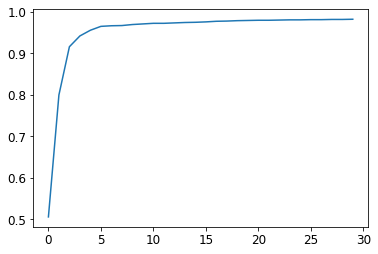

In [223]:
plt.plot(L(learn.recorder.values).itemgot(2));

 We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.